In [53]:
"""
This is slightly modified version of the notebook in the pymatgen/examples folder
"""
import numpy as np

from pymatgen.matproj.rest import MPRester
from pymatgen.core.ion import Ion
from pymatgen import Element

from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.analysis.pourbaix.entry import PourbaixEntry, IonEntry
from pymatgen.analysis.pourbaix.maker import PourbaixDiagram
from pymatgen.analysis.pourbaix.plotter import PourbaixPlotter
from pymatgen.entries.compatibility import MaterialsProjectCompatibility, AqueousCorrection

%matplotlib inline

useful function for filtering duplicate entries.

In [5]:
def contains_entry(entry_list, entry):
    for e in entry_list:
        if e.entry_id == entry.entry_id or \
            (abs(entry.energy_per_atom 
                - e.energy_per_atom) < 1e-6 and
                    entry.composition.reduced_formula ==
             e.composition.reduced_formula):
            return True

In [10]:
#This initializes the REST adaptor. Put your own API key in.
a = MPRester("tUDO4pcZ81IHhw3a")

In [54]:
#Entries are the basic unit for thermodynamic and other analyses in pymatgen.
#This gets all entries belonging to the Fe-O-H system.
entries = a.get_entries_in_chemsys(['Fe', 'O', 'H'])

In [84]:
#exp_entries = a.get_exp_entry("SnO")
#print exp_entries
DFT_Data = {}
import yaml
for ent in entries:
    DFT_Data.update({ent.composition.formula:ent.energy})


In [85]:
with open('DFT_FeOH.yaml','w') as yamfile:
    yaml.dump(DFT_Data, yamfile, default_flow_style=False)

In [86]:
yaml.load(open('DFT_FeOH.yaml'))

{'Fe1': -8.31266428,
 'Fe1 H1': -11.8135345,
 'Fe1 H1 O2': -28.08261191,
 'Fe1 H2 O2': -32.29983393,
 'Fe1 H3': -17.52759945,
 'Fe1 O1': -15.90710818,
 'Fe1 O2': -22.30417569,
 'Fe10 O11': -174.45994504,
 'Fe10 O14': -193.70198301,
 'Fe11 O12': -191.26877137000002,
 'Fe12 O12': -198.97163238,
 'Fe12 O13': -207.25752108,
 'Fe12 O16': -230.13741406999998,
 'Fe12 O18': -233.17108267999998,
 'Fe12 O24': -265.23717575,
 'Fe13 O14': -216.26811935,
 'Fe13 O15': -227.98661347,
 'Fe14 O15': -237.19155325000003,
 'Fe14 O16': -248.88203259,
 'Fe15 O16': -257.18807836,
 'Fe16 H16 O32': -443.93843547,
 'Fe16 H20 O34': -475.36958252,
 'Fe16 O18': -281.14962684,
 'Fe16 O24': -322.42751699,
 'Fe16 O32': -353.710741,
 'Fe17 O18': -291.71916361,
 'Fe2': -16.7278538,
 'Fe2 H2 O4': -56.41867967,
 'Fe2 O2': -33.16405348,
 'Fe2 O4': -45.26742012,
 'Fe2 O6': -51.905008499999994,
 'Fe20 O22': -349.46194576000005,
 'Fe20 O32': -398.5544822,
 'Fe21 O23': -365.95350949,
 'Fe21 O27': -388.42010648999997,
 'Fe21 O

In [65]:
from pymatgen.entries.computed_entries import ComputedEntry, Composition

In [66]:
ComputedEntry(composition='Fe2',energy=ent.energy)

ComputedEntry Fe2
Energy = -16.7279
Correction = 0.0000
Parameters:
Data:

In [12]:
#Dictionary of ion:energy, where the energy is the formation energy of ions from 
#the NBS tables. (Source: NBS Thermochemical Tables; FeO4[2-]: Misawa T., Corr. Sci., 13(9), 659-676 (1973))
ion_dict = {"Fe[2+]":-0.817471, "Fe[3+]":-0.0478, "FeO2[2-]":-3.06055, "FeOH[+]":-2.8738,
            "FeOH[2+]":-2.37954, "HFeO2[-]":-3.91578, "Fe(OH)2[+]":-4.54022, "Fe2(OH)2[4+]":-4.84285,
            "FeO2[-]":-3.81653, "FeO4[2-]":-3.33946, "Fe(OH)3(aq)":-6.83418, "Fe(OH)2[+]":-4.54022}


In [13]:
elements = set()
data = []
for entry in entries:
    elements.update(entry.composition.elements)
#print elements
for entry in entries:
    comp = entry.composition
    #print comp
    row = [comp.get_atomic_fraction(el) for el in elements]
    row.append(entry.energy_per_atom)
    data.append(row)
data = np.array(data)
#print data
#print data[:, 1:]

Solvent corrections

In [95]:
# Run aqueouscorrection on the entries
aqcompat = AqueousCorrection("/home/joshua/Software/Current_MPInterfaces/MPInterfaces/mpinterfaces/mat2d/pourbaix/AqueousIon.yaml")
entries_aqcorr = list()
print (len(entries))
for entry in entries:
    aq_corrected_entry = aqcompat.correct_entry(entry)
    if not contains_entry(entries_aqcorr, aq_corrected_entry):
        entries_aqcorr.append(aq_corrected_entry)

# Generate a phase diagram to consider only solid entries stable in water. 
#for e in entries_aqcorr:
#    print e.name
print (len(entries_aqcorr))
pd = PhaseDiagram(entries_aqcorr)
#for e in pd.qhull_entries:
#    print e.name
#for el in pd.el_refs:
#    print el.name
#print pd.facets
#print pd.qhull_data


154
144


Solid state pourbaix entries

In [89]:
stable_solids = pd.stable_entries
for ss in stable_solids:
    print (ss.name)
    print (ss.composition.get_reduced_composition_and_factor())#[1]
    
stable_solids_minus_h2o = [entry for entry in stable_solids if 
                           entry.composition.reduced_formula not in ["H2", "O2", "H2O", "H2O2"]]

pbx_solid_entries = []
for entry in stable_solids_minus_h2o:
    pbx_entry = PourbaixEntry(entry)
    pbx_entry.g0_replace(pd.get_form_energy(entry))
    pbx_entry.reduced_entry()
    pbx_solid_entries.append(pbx_entry)

Fe2O3
(Comp: Fe2 O3, 8)
H2
(Comp: H2, 0.5)
FeH
(Comp: Fe1 H1, 1)
O2
(Comp: O2, 4.0)
Fe3O4
(Comp: Fe3 O4, 2)
FeO
(Comp: Fe1 O1, 2)
Fe
(Comp: Fe1, 1)
H2O
(Comp: H2 O1, 4)


Ion pourbaix entries

In [90]:
#Dictionary of reference state:experimental formation energy (from O. Kubaschewski) for reference state.
ref_state = "Fe2O3"
ref_dict = {"Fe2O3": -7.685050670886141}

# Calculate DFT reference energy for ions (See Persson et al, PRB (2012))
ref_entry = [entry for entry in stable_solids_minus_h2o if entry.composition.reduced_formula == ref_state][0]
ion_correction = pd.get_form_energy(ref_entry)/ref_entry.composition.get_reduced_composition_and_factor()[1] - ref_dict[ref_state]
 
el = Element("Fe")
pbx_ion_entries = []

# Get PourbaixEntry corresponding to each ion
for key in ion_dict:
    comp = Ion.from_formula(key)
    factor = comp.composition[el] / (ref_entry.composition[el] / ref_entry.composition.get_reduced_composition_and_factor()[1])
    #experimental energy + correction
    energy = ion_dict[key] + ion_correction * factor
    pbx_entry_ion = PourbaixEntry(IonEntry(comp, energy))
    pbx_entry_ion.name = key
    pbx_ion_entries.append(pbx_entry_ion)

([0.0, -2.0, -2.409760203931931], [-1.0, -2.0, -2.0077892039319316], [0.0, -3.0, -1.640089203931931], [-1.0, -3.0, -1.513529203931931], [-3.0, -3.0, -1.3927645393750012], [-1.0, -3.0, -1.3781142039319314], [-2.6666666666666665, -2.6666666666666665, -1.371699215000004], [-2.0, -2.0, -1.2452629462500027], [-2.0, -3.0, -1.2159092039319308], [-3.0, -3.0, -1.0515692039319298], [-3.0, -2.0, -0.5914692039319309], [-4.0, -3.0, -0.4922192039319313], [1.0, 1.0, -0.4787686886199989], [0.0, 0.0, 0.0], [-4.0, -2.0, 0.2637607960680679], [-8.0, -6.0, 4.901450796068069])


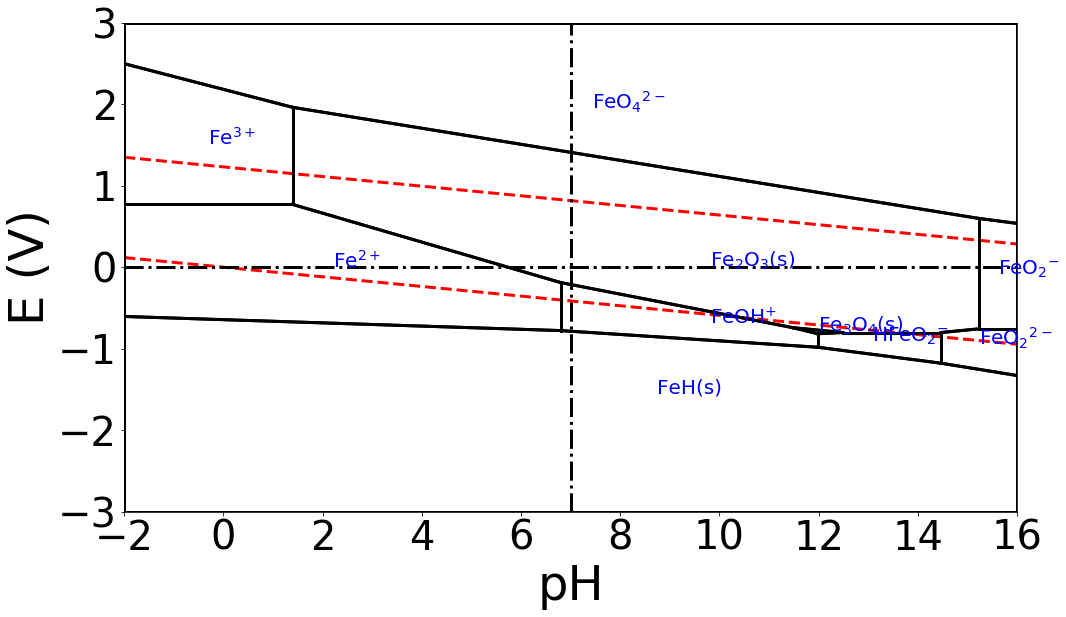

In [92]:
# Generate and plot Pourbaix diagram
#Each bulk solid/ion has a free energy g of the form:
#g = g0_ref + 0.0591 * log10(conc) - nO * mu_H2O + (nH - 2nO) * pH + phi * (-nH + 2nO + q)
all_entries = pbx_solid_entries + pbx_ion_entries
pourbaix = PourbaixDiagram(all_entries)
print (pourbaix._qhull_data)
plotter = PourbaixPlotter(pourbaix)
plotter.plot_pourbaix(limits=[[-2, 16],[-3, 3]])

In [30]:
import os
from mpinterfaces.mat2d.pourbaix.analysis import plot_pourbaix_diagram

In [48]:
with open('AqueousIon.yaml', 'w') as yaml_file:
    yaml.dump({'AqueousCompoundEnergies':yaml.load(open('ion_corrections.yaml')),'Name':[]}, yaml_file, default_flow_style=False)


Help on class AqueousCorrection in module pymatgen.entries.compatibility:

class AqueousCorrection(AqueousCorrection)
 |  This class implements aqueous phase compound corrections for elements
 |  and H2O.
 |  
 |  Args:
 |      config_file: Path to the selected compatibility.yaml config file.
 |  
 |  Method resolution order:
 |      AqueousCorrection
 |      AqueousCorrection
 |      Correction
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(cls, *args, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  __wrapped__ = <class 'pymatgen.entries.compatibility.AqueousCorrection...
 |      This class implements aqueous phase compound corrections for elements
 |      and H2O.
 |      

In [87]:
yaml.load(open('/home/joshua/Software/Current_MPInterfaces/MPInterfaces/mpinterfaces/mat2d/pourbaix/AqueousIon.yaml'))

{'AqueousCompoundEnergies': {'Ag': -0.121,
  'Al': 0.614,
  'As': 0.197,
  'Au': -0.548,
  'B': 0.353,
  'Ba': 0.403,
  'Be': 0.376,
  'Bi': -0.535,
  'C': 0.579,
  'Ca': 0.105,
  'Cd': 0.267,
  'Ce': 0.529,
  'Co': 0.871,
  'Cr': 0.602,
  'Cs': 'Element not finished and oxide not finished',
  'Cu': 0.065,
  'Dy': 0.235,
  'Er': 0.293,
  'Eu': 'Element not finished and oxide not finished',
  'Fe': 0.366,
  'Ga': 0.536,
  'Gd': -0.061,
  'Ge': 0.901,
  'Hf': 0.313,
  'Hg': -2.233,
  'Ho': -20.11,
  'In': 0.363,
  'Ir': -0.53,
  'K': -0.087,
  'La': 'Element not finished and oxide not finished',
  'Li': -0.006,
  'Lu': 0.027,
  'Mg': 0.281,
  'Mn': 1.422,
  'Mo': 0.379,
  'N': -6.383,
  'Na': -0.011,
  'Nb': 0.133,
  'Nd': 0.585,
  'Ni': 1.122,
  'Np': 0.946,
  'Os': -0.38,
  'P': 0.664,
  'Pb': -0.309,
  'Pd': -0.106,
  'Pr': 1.806,
  'Pt': -3.324,
  'Pu': 1.018,
  'Rb': -0.475,
  'Re': -0.483,
  'Rh': -0.286,
  'Ru': -0.483,
  'Sb': 0.004,
  'Sc': 0.518,
  'Se': -0.096,
  'Si': 0.932,
